In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rebound
%matplotlib inline
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch

plt.style.use('paper.mplstyle')

In [2]:
csvpath = '../csvs/random/random_features/'
dfrand = pd.read_csv(csvpath+'random1e7featuressplit.csv', index_col=0)
dfrand.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,instability_time,KSpval,tlyap10,megno10,Nlyap10
0,1007.0,0.133196,5.587629,0.464593,0.014738,0.010563,2.423315e-08,1.740396e+05,0.069176,167.062457,98.031355,1041.763579
1,1021.0,0.181262,6.003999,0.327314,0.010287,0.007410,5.811603e-09,2.689656e+06,0.536277,NaN,NaN,NaN
2,1025.0,0.153687,5.794418,0.385985,0.012358,0.008756,1.170601e-08,6.744501e+05,0.042792,1243.771432,54.339329,542.262112
3,1041.0,0.127597,5.730234,0.494415,0.015324,0.011150,2.919534e-08,7.144123e+05,0.000001,9095.502208,9.486404,78.545670
4,10518.0,0.144064,6.465849,0.431597,0.013325,0.009608,1.638141e-08,9.271300e+06,0.006915,16753.088367,53.432842,553.408423


In [3]:
dfrand.shape

(244, 12)

In [4]:
cutoffrand = 2.7e-18 # from instabilitytimehistograms.ipynb
badrand = (dfrand['KSpval'] < cutoffrand)
badrand.sum()

18

In [5]:
print("Fraction of bad random systems:{0:.3f}".format(badrand.sum()/dfrand.shape[0]))

Fraction of bad random systems:0.074


In [6]:
dfrand[(dfrand['KSpval'] < cutoffrand) & (dfrand['Nlyap10'] > 100)]

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,instability_time,KSpval,tlyap10,megno10,Nlyap10
100,1819.0,0.57109,4.329505,0.104577,0.003297,0.002360,6.056244e-11,20265.756551,2.153892e-43,102.958764,21.641818,196.833720
211,2300.0,0.47533,4.577946,0.129484,0.004108,0.002954,1.473067e-10,66076.421954,1.370185e-22,338.297556,18.969901,195.320424


In [7]:
csvpath = '../csvs/resonant/resonant_features/'
dfres = pd.read_csv(csvpath+'res1e7featuressplit2.csv', index_col=0)
dfres.head()

,ID,Mean,Sigma,instability_time,KSpval,tlyap10,megno10,Nlyap10
3,3.0,6.837504,0.306543,2.287671e+06,0.413486,16155.249034,13.950857,141.605409
4,4.0,5.687568,0.239838,9.668931e+05,0.001478,96689.311474,2.104692,10.000000
5,5.0,5.797549,0.456784,5.755894e+05,0.935112,691.667984,80.773003,832.175823
8,8.0,5.891151,0.417529,2.930966e+05,0.718919,2362.272279,12.443361,124.074012
13,13.0,4.644210,0.256174,4.506090e+04,0.000248,4506.103381,2.022401,9.999969


In [8]:
dfres.shape

(136, 8)

In [9]:
cutoffres = 1.2e-5
badres = dfres['KSpval'] < cutoffres
print("Fraction of bad systems:{0:.3f}".format(badres.sum()/dfres.shape[0]))

Fraction of bad systems:0.059


In [10]:
import os

def collision(reb_sim, col):
    reb_sim.contents._status=5
    return 0

def es(system, Nshadows, tmax=1.e4):
    distpath = '../../stabilitydataset/data/resonant_distributions/'
    folder = distpath + "Res_sys_{0}_1e8/simulation_archives/".format(system)#ic{1:0=7d}.bin".format(system, 0)
    root, dirs, files = next(os.walk(folder))
    Nsys=0
    for file in files:
        try:
            sim = rebound.SimulationArchive(folder+file)[0]
            Nsys += 1
        except:
            print('Didnt load')
    Nout = 1000
    es = np.zeros((Nsys, Nout))
    for j, file in enumerate(files[:Nshadows]):
        sim = rebound.SimulationArchive(folder+file)[0]
        sim.collision_resolve = collision
        sim.exit_max_distance = 100.
        ps = sim.particles
        times = np.logspace(0, np.log10(tmax), Nout)
        for i, time in enumerate(times):
            try:
                sim.integrate(time)
                es[j, i] = ps[2].e
            except:
                break
    
    return times, es

In [11]:
%%time
Nshadows = 50
exp = 60
lognorm = 14

timesexp, eexp = es(60, Nshadows=Nshadows, tmax=2.e4)
timeslognorm, elognorm = es(14, Nshadows=Nshadows, tmax=1.e5)

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


CPU times: user 1min 26s, sys: 43.3 ms, total: 1min 26s
Wall time: 1min 26s


In [12]:
expsample = dfres[dfres['ID']==exp]
lognormsample = dfres[dfres['ID']==lognorm]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

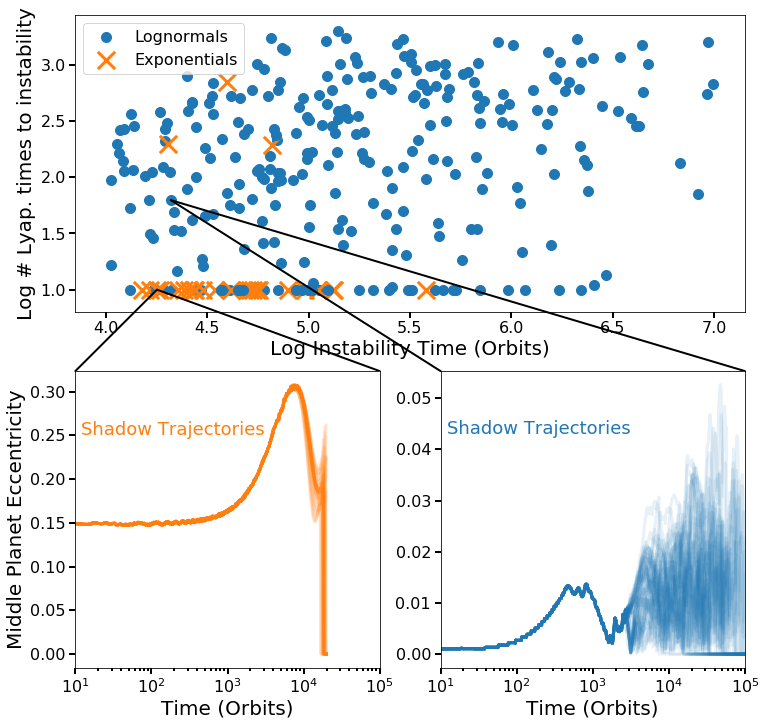

In [13]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = plt.subplot(gs[0, 0:])
cmap = plt.get_cmap("tab10")
ax1.scatter(np.log10(dfrand['instability_time'])[~badrand], np.log10(dfrand['Nlyap10'])[~badrand], c=cmap(0), marker='o', label='Lognormals')
ax1.scatter(np.log10(dfrand['instability_time'])[badrand], np.log10(dfrand['Nlyap10'])[badrand], c=cmap(1), marker='x', s=300, label='Exponentials')
ax1.scatter(np.log10(dfres['instability_time'])[~badres], np.log10(dfres['Nlyap10'])[~badres], c=cmap(0), marker='o')
ax1.scatter(np.log10(dfres['instability_time'])[badres], np.log10(dfres['Nlyap10'])[badres], c=cmap(1), marker='x', s=300)
ax1.set_xlabel('Log Instability Time (Orbits)')
ax1.set_ylabel('Log # Lyap. times to instability')
ax1.legend()

ax2 = plt.subplot(gs[1, 0])
for i in range(Nshadows):
    ax2.plot(timesexp, eexp[i,:], c=cmap(1), alpha=0.1)
ax2.set_xscale('log')

ax3 = plt.subplot(gs[1, 1])
for i in range(Nshadows):
    ax3.plot(timeslognorm, elognorm[i,:], c=cmap(0), alpha=0.1)
ax3.set_xscale('log')

ax2.set_xlim([10,1.e5])
ax3.set_xlim([10,1.e5])
ax2.set_ylabel('Middle Planet Eccentricity')
ax2.set_xlabel('Time (Orbits)')
ax3.set_xlabel('Time (Orbits)')

ax1.add_artist(ConnectionPatch(xyA=(np.log10(expsample['instability_time']), np.log10(expsample['Nlyap10'])), xyB=(0, 1), coordsA="data", coordsB="axes fraction",
                      axesA=ax1, axesB=ax2, color="k", linewidth=2))
ax1.add_artist(ConnectionPatch(xyA=(np.log10(expsample['instability_time']), np.log10(expsample['Nlyap10'])), xyB=(1, 1), coordsA="data", coordsB="axes fraction",
                      axesA=ax1, axesB=ax2, color="k", linewidth=2))
ax1.add_artist(ConnectionPatch(xyA=(np.log10(lognormsample['instability_time']), np.log10(lognormsample['Nlyap10'])), xyB=(0, 1), coordsA="data", coordsB="axes fraction",
                      axesA=ax1, axesB=ax3, color="k", linewidth=2))
ax1.add_artist(ConnectionPatch(xyA=(np.log10(lognormsample['instability_time']), np.log10(lognormsample['Nlyap10'])), xyB=(1, 1), coordsA="data", coordsB="axes fraction",
                      axesA=ax1, axesB=ax3, color="k", linewidth=2))

ax2.text(12, 0.25, 'Shadow Trajectories', c=cmap(1), fontsize=18)
ax3.text(12, 0.043, 'Shadow Trajectories', c=cmap(0), fontsize=18)
fig.savefig('fig2.pdf', bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


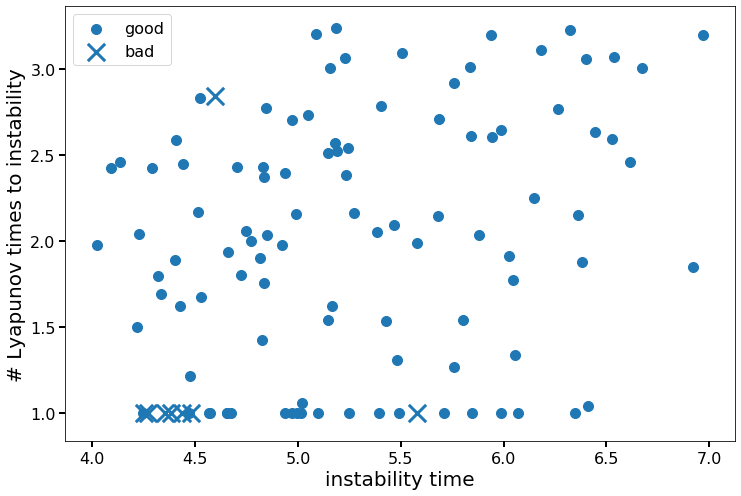

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(np.log10(dfres['instability_time'])[~badres], np.log10(dfres['Nlyap10'])[~badres], c=cmap(0), marker='o', label='good')
ax.scatter(np.log10(dfres['instability_time'])[badres], np.log10(dfres['Nlyap10'])[badres], c=cmap(0), marker='x', s=300, label='bad')
ax.set_xlabel('instability time')
ax.set_ylabel('# Lyapunov times to instability')
ax.legend()

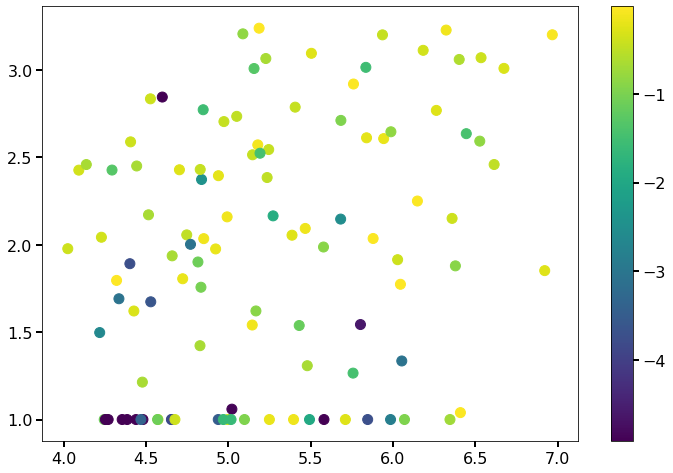

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
cm = plt.cm.get_cmap('RdYlBu')
cb = ax.scatter(np.log10(dfres['instability_time']), np.log10(dfres['Nlyap10']), c=np.log10(dfres['KSpval']), vmin=np.log10(cutoffres))
plt.colorbar(cb)

In [16]:
dfres[badres].sort_values('instability_time')

,ID,Mean,Sigma,instability_time,KSpval,tlyap10,megno10,Nlyap10
60,60.0,4.283397,0.085474,17874.417924,2.978530e-20,1787.441792,2.012342,10.000000
89,89.0,4.266151,0.018597,18586.741139,2.029285e-18,1858.698363,1.515870,9.999870
165,165.0,4.491704,0.309658,22615.560599,1.091034e-13,2261.573380,2.002199,9.999923
166,166.0,4.616113,0.359195,24248.884511,2.999794e-10,2424.905772,2.354679,9.999929
143,143.0,4.443182,0.011909,27436.827945,2.130629e-25,2743.707043,1.968661,9.999912
95,95.0,4.520902,0.142438,30236.965204,4.016638e-36,3023.710377,1.621372,9.999954
34,34.0,4.728933,0.396513,39653.986882,8.191314e-09,56.581853,70.628634,700.825174
49,49.0,5.570552,0.581446,380981.445369,5.515796e-20,38098.154923,2.010057,9.999997


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


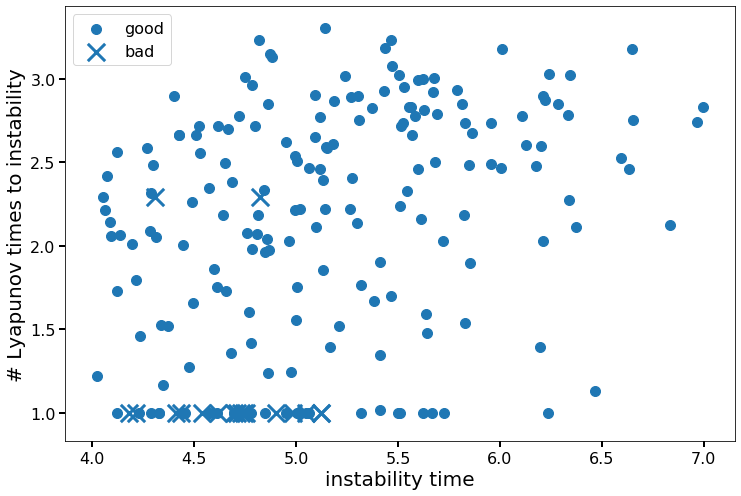

In [17]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(np.log10(dfrand['instability_time'])[~badrand], np.log10(dfrand['Nlyap10'])[~badrand], c=cmap(0), marker='o', label='good')
ax.scatter(np.log10(dfrand['instability_time'])[badrand], np.log10(dfrand['Nlyap10'])[badrand], c=cmap(0), marker='x', s=300, label='bad')
ax.set_xlabel('instability time')
ax.set_ylabel('# Lyapunov times to instability')
ax.legend()

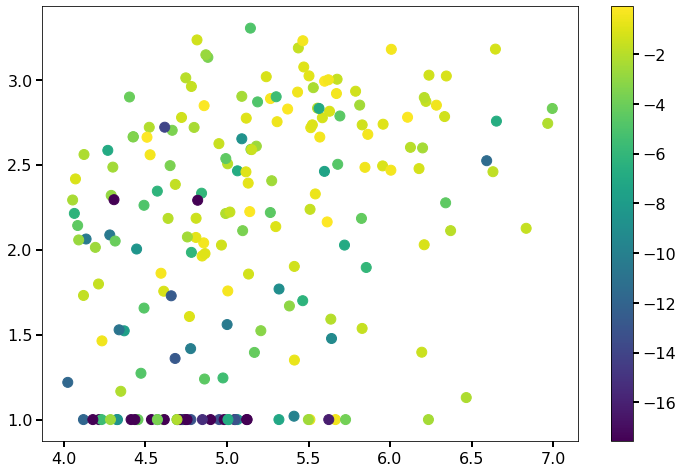

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
cm = plt.cm.get_cmap('RdYlBu')
cb = ax.scatter(np.log10(dfrand['instability_time']), np.log10(dfrand['Nlyap10']), c=np.log10(dfrand['KSpval']), vmin=np.log10(cutoffrand))
plt.colorbar(cb)